In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# We will try to import SMOTE, hoping it's available in the environment
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    SMOTE_AVAILABLE = False
    print("Warning: imblearn is not available. SMOTE will not be used.")

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:

df = pd.read_csv('..\\..\\data\\csv\\FY_2022-2025.csv')
# Cleaning
df.columns = df.columns.str.strip()

In [3]:
def run_advanced_model_pipeline(df, condition_name):
    """
    This function runs the full advanced pipeline for a given condition.
    """
    print(f"\n--- Starting Advanced Modeling Pipeline for {condition_name} ---")

    target_col = f'Penalty indicator for {condition_name}'
    err_col = f'ERR for {condition_name}'
    median_err_col = f'Peer group median ERR for {condition_name}'

    
    df_condition = df.copy() #just to ensure we don't modify the original

    # Drop rows where key columns have missing values to ensure data quality
    df_condition.dropna(subset=[target_col, err_col, median_err_col], inplace=True)
    df_condition[target_col] = df_condition[target_col].apply(lambda x: 1 if x == 'Y' else 0)

    # Base features
    base_features = ['Payment adjustment factor', 'Payment reduction percentage', 'Dual proportion',
                     'Peer group assignment', 'Neutrality modifier', err_col, median_err_col]

    # Convert feature columns to numeric
    for col in base_features:
        df_condition[col] = pd.to_numeric(df_condition[col], errors='coerce')
        df_condition[col].fillna(df_condition[col].mean(), inplace=True)

    # Feature test: 'ERR_vs_median'
    df_condition['ERR_vs_median'] = df_condition[err_col] - df_condition[median_err_col]
    print("New feature 'ERR_vs_median' created.")
    
    # Final features list for the model
    final_features = ['Payment adjustment factor', 'Payment reduction percentage', 'Dual proportion',
                      'Peer group assignment', 'Neutrality modifier', 'ERR_vs_median']

    X = df_condition[final_features]
    y = df_condition[target_col]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    #testing with SMOTE
    if SMOTE_AVAILABLE:
        print("\nApplying SMOTE to balance the training data...")
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        print(f"Class distribution after SMOTE:\n{y_train_resampled.value_counts()}")
    else:
        print("\nSMOTE not available, proceeding with original imbalanced data.")
        X_train_resampled, y_train_resampled = X_train, y_train


    # training and tuning models
    print("\n--- Starting Model Training and Tuning ---")
    # Define models and their hyperparameters for tuning
    models = {
        'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced' if not SMOTE_AVAILABLE else None),
        'GradientBoosting': GradientBoostingClassifier(random_state=42)
    }

    # Define hyperparameter grids for tuning
    param_grid = {
        'RandomForest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
        'GradientBoosting': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]}
    }

    # loop through each model for tuning and evaluation
    for model_name, model in models.items():
        print(f"\n--- Tuning and Evaluating {model_name} for {condition_name} ---")
        
        # Using GridSearchCV to find the best model parameters
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name],
                                   cv=3, n_jobs=-1, scoring='roc_auc', verbose=1)
        grid_search.fit(X_train_resampled, y_train_resampled)
        
        best_model = grid_search.best_estimator_
        print(f"Best Parameters found: {grid_search.best_params_}")

        # test set evaluation
        y_pred = best_model.predict(X_test)
        
        print(f"\n--- Final Evaluation for Tuned {model_name} ---")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=['No Penalty', 'Penalty']))
        
        # confusion Matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='cividis',
                    xticklabels=['No Penalty', 'Penalty'], yticklabels=['No Penalty', 'Penalty'])
        plt.title(f'Advanced Confusion Matrix for {model_name} ({condition_name})')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        # Save the figure to a file
        #plt.savefig(f'{condition_name.lower()}_{model_name.lower()}_advanced_matrix.png')
        #print(f"Confusion matrix saved to '{condition_name.lower()}_{model_name.lower()}_advanced_matrix.png'")
        print(f"--- End of {model_name} Pipeline ---")


--- Starting Advanced Modeling Pipeline for AMI ---
New feature 'ERR_vs_median' created.

Applying SMOTE to balance the training data...
Class distribution after SMOTE:
Penalty indicator for AMI
1    4258
0    4258
Name: count, dtype: int64

--- Starting Model Training and Tuning ---

--- Tuning and Evaluating RandomForest for AMI ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters found: {'max_depth': 20, 'n_estimators': 200}

--- Final Evaluation for Tuned RandomForest ---
Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

  No Penalty       0.95      0.90      0.92      1825
     Penalty       0.80      0.89      0.84       801

    accuracy                           0.90      2626
   macro avg       0.87      0.90      0.88      2626
weighted avg       0.90      0.90      0.90      2626

--- End of RandomForest Pipeline ---

--- Tuning and Evaluating GradientBoosting for AMI ---
Fitting 3 folds for each of 4 ca

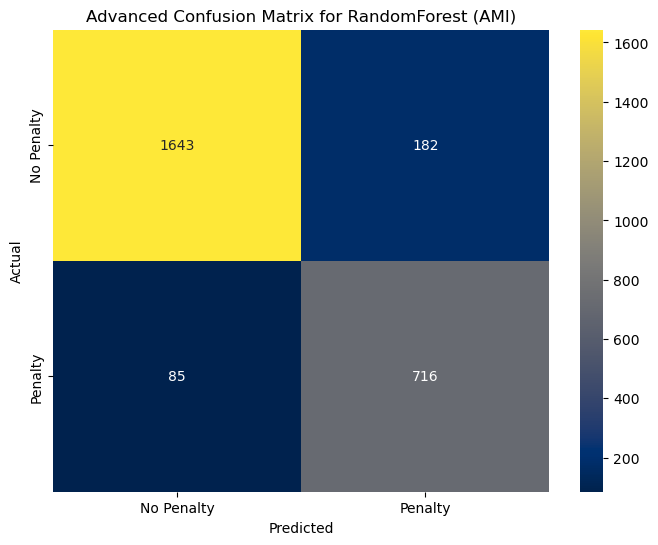

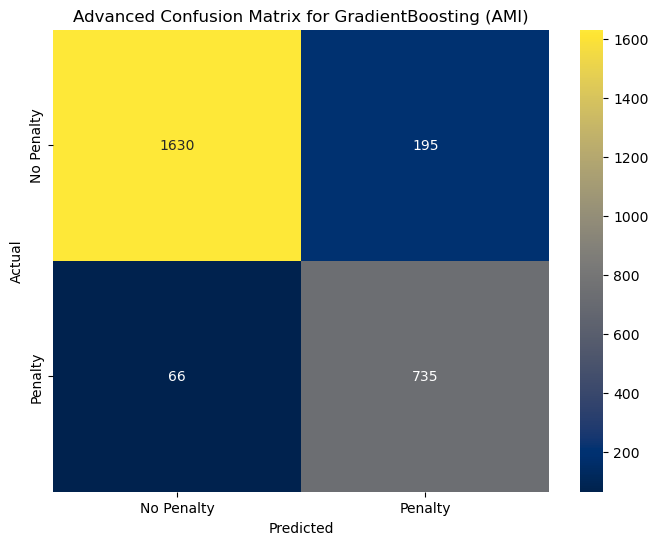

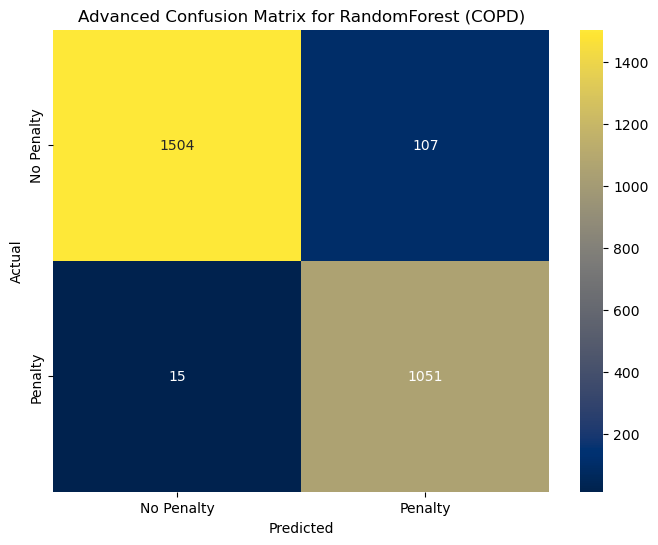

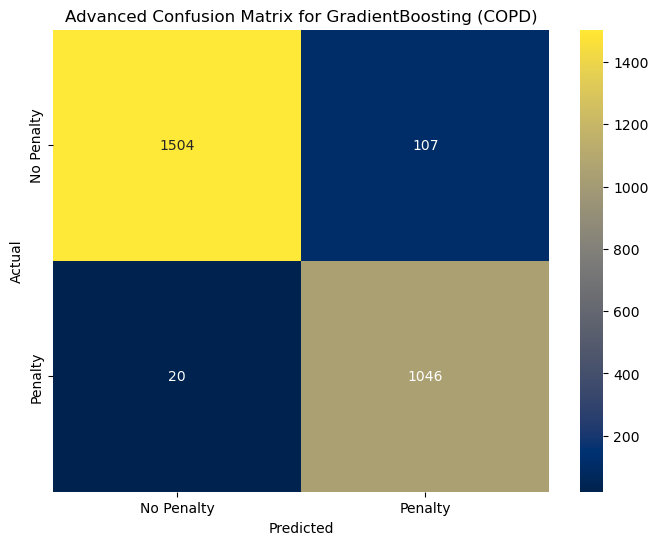

In [5]:
run_advanced_model_pipeline(df, 'AMI')
run_advanced_model_pipeline(df, 'COPD')